In [1]:
import os
import numpy as np
import seaborn as sns # for plots
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from scipy import stats as sps # to calcualte confidence intervals, etc
from adjustText import adjust_text # to adjust the text labels in the plots (pip install adjustText)
from scipy.stats import ttest_rel, f_oneway,ttest_1samp
from dataset import *

from statsmodels.stats.anova import AnovaRM # perform F test

ModuleNotFoundError: No module named 'dataset'

In [6]:
# setting directories
base_dir = '/Volumes/diedrichsen_data$/data/FunctionalFusion'
if not Path(base_dir).exists():
    base_dir = '/srv/diedrichsen/data/FunctionalFusion'
if not Path(base_dir).exists():
    base_dir = '/cifs/diedrichsen/data/FunctionalFusion'
atlas_dir = base_dir + '/Atlases'

conn_dir = '/cifs/diedrichsen/data/Cerebellum/connectivity'

In [23]:
# Functions
# prepare dataframe for plotting
def prep_df(dataframe, agg_kw = {}, groupby = "cond_name"):
    """
    prepare the region dataframe to do the scatter plot
    gets the mean across subjects (data point) and std of residuals
    Args:
        dataframe (pd.DataFrame) - dataframe with residuals info 
        agg_kw (dict) - dictionary determining info for dataframe aggregation

    Returns:
    g_df (pd.DataFrame) - dataframe ready for putting into the scatterplot function
    """
    # group by condition
    grouped = dataframe.groupby([groupby])
    g_df = grouped.agg(agg_kw)
    
    g_std = grouped.std(numeric_only=True)
    g_df["Y_CI"] = grouped.Y.apply(sps.sem) * 1.96
    g_df["X_CI"] = grouped.X.apply(sps.sem)*1.96
    
    return g_df


# plotting:
def make_plot(dataframe, hue = "cond_name", style = "cond_name", height = 4, aspect = 1,hue_order = ['consonant_string', 'pseudoword_list', 'jabberwocky', 'word_list', 'simple_sentence', 'complex_sentence']):
    """
    make scatterplot
    uses FacetGrid 
    Args: 
    dataframe (pd.DataFrame) - output from prep_df
    hue (str)      - column name to be used to determine color
    style (str)    - column name to be used to determine shape of the marker
    label (str)    - column name to be used to determine the label of the data points
    height (int)   - int to determine the height of the plot
    aspect (float) - floating number to determine the aspect ratio of the plot
    """
    g = sns.FacetGrid(dataframe,  height=height, aspect=aspect)
    # do the scatter plot
    g.map_dataframe(sns.scatterplot, x="X", y="Y", 
                                    style = style, hue = hue, s = 50,hue_order=['consonant_string','pseudoword_list','jabberwocky','word_list','simple_sentence','complex_sentence'])
    g.add_legend()

    # fit the regression on top of the scatterplot
    g.map_dataframe(sns.regplot, x="X", y="Y", 
                        fit_reg=False, 
                        scatter_kws={"s": 0}, # size is set to 0 so that it doesn't cover the markers created in the scatterplot step 
                        line_kws={'label':"Linear Reg", "color": 'grey'})

    # # put the errorbars in 
    # g.map(plt.errorbar, x = df_preped['X'], 
    #                     y = df_preped['Y'], 
    #                     yerr = df_preped['err'],
    #                     elinewidth=1, 
    #                     fmt='none', # no marker will be used when plotting the error bars
    #                     color='grey', 
    #                     ecolor='0.9'
                # )
    # set labels
    g.set_xlabels('Cerebellar Language (a.u.)')
    g.set_ylabels('Cerebellar MD (a.u.)')


In [13]:
df_path = os.path.join(conn_dir, "IBC", "sc_IBC_ses-rsvplanguage_ff_languageLR-vs-ff_wmLR-shift.tsv")
df = pd.read_csv(df_path, sep="\t")
df = df[df['cond_name'] != 'probe']

df_averaged = df.groupby(['sn', 'cond_name']).mean()
df_averaged = df_averaged.drop(columns=['half','res','coef','R2'])
df_averaged = df_averaged.reset_index()
df_averaged

/tmp/ipykernel_265987/1615065767.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_averaged = df.groupby(['sn', 'cond_name']).mean()


,sn,cond_name,cond_num_uni,n_rep,Unnamed: 0,reg_id,X,Y
0,0.0,complex_sentence,190.0,1.0,31.5,1.0,-0.124759,-0.072697
1,0.0,consonant_string,191.0,1.0,32.5,2.0,-0.154194,-0.029730
2,0.0,jabberwocky,192.0,1.0,33.5,3.0,-0.151049,-0.058120
3,0.0,pseudoword_list,194.0,1.0,35.5,5.0,-0.130715,-0.050052
4,0.0,simple_sentence,195.0,1.0,36.5,6.0,-0.140000,-0.077967
...,...,...,...,...,...,...,...,...
67,11.0,consonant_string,191.0,1.0,32.5,2.0,-0.101424,-0.021169
68,11.0,jabberwocky,192.0,1.0,33.5,3.0,-0.098266,-0.043427
69,11.0,pseudoword_list,194.0,1.0,35.5,5.0,-0.089936,-0.040437
70,11.0,simple_sentence,195.0,1.0,36.5,6.0,-0.094590,-0.065460


In [19]:
# prepare df for plotting
# by setting non-numeric fields to 'first', we make sure that they are not removed from the final dataframe
agg_kw= {'cond_name': 'first', 'X': np.mean, 'Y': np.mean}
df_preped = prep_df(df_averaged ,groupby = "cond_name", agg_kw=agg_kw)

df_preped


,cond_name,X,Y,Y_CI,X_CI
cond_name,,,,,
complex_sentence,complex_sentence,-0.092288,-0.061568,0.022368,0.024791
consonant_string,consonant_string,-0.089565,-0.025500,0.023915,0.020589
jabberwocky,jabberwocky,-0.090943,-0.043171,0.023126,0.021505
pseudoword_list,pseudoword_list,-0.092725,-0.048137,0.024347,0.019815
simple_sentence,simple_sentence,-0.086234,-0.058858,0.018417,0.019729
word_list,word_list,-0.086399,-0.042296,0.021187,0.016736


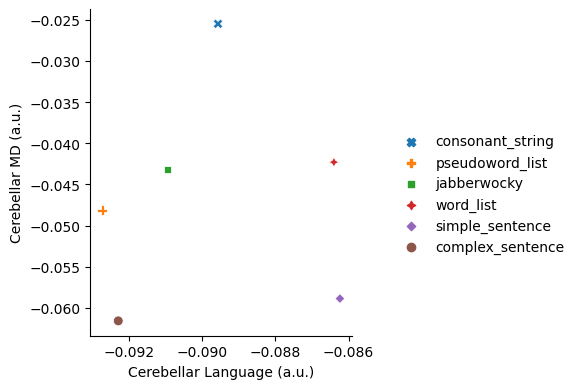

In [24]:
make_plot(df_preped, hue = "cond_name", style = "cond_name", height = 4, aspect = 1)